#### 1. Drive Bağlantısı

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 2. Dataseti Arşivden Çıkarma

In [3]:
%cd /content/drive/MyDrive/titresim

/content/drive/MyDrive/titresim


In [4]:
%ls

 Averaged_BearingTest_Dataset.csv   model.h5     'Sensor Data'/
 data.zip                           scaler_data   titresim_analizi.ipynb


In [5]:
!unzip data.zip

Archive:  data.zip
replace Sensor Data/2004.02.16.08.32.39? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Sensor Data/2004.02.16.08.32.39  
replace Sensor Data/2004.02.16.05.52.39? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Sensor Data/2004.02.16.05.52.39  
  inflating: Sensor Data/2004.02.16.05.32.39  
  inflating: Sensor Data/2004.02.16.08.22.39  
  inflating: Sensor Data/2004.02.16.06.12.39  
  inflating: Sensor Data/2004.02.16.08.42.39  
  inflating: Sensor Data/2004.02.16.05.22.39  
  inflating: Sensor Data/2004.02.16.04.52.39  
  inflating: Sensor Data/2004.02.16.04.12.39  
  inflating: Sensor Data/2004.02.16.03.52.39  
  inflating: Sensor Data/2004.02.16.07.32.39  
  inflating: Sensor Data/2004.02.16.08.52.39  
  inflating: Sensor Data/2004.02.16.07.22.39  
  inflating: Sensor Data/2004.02.16.06.52.39  
  inflating: Sensor Data/2004.02.16.07.02.39  
  inflating: Sensor Data/2004.02.16.04.32.39  
  inflating: Sensor Data/2004.02.16.03.22.39  
  inflating: Sensor 

#### 3. Kütüphaneler


In [6]:
import os
import numpy as np
import pandas as pd
from numpy.random import seed

In [7]:
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

In [8]:
import tensorflow as tf
from keras.models import Model

from keras import regularizers
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector

In [9]:
seed(10)
tf.random.set_seed(10)

In [10]:
%pwd

'/content/drive/MyDrive/titresim'

#### 4. Verileri İnceleme ve Görselleştirme

In [11]:
data_dir = 'Sensor Data'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ['Rulman 1', 'Rulman 2', 'Rulman 3', 'Rulman 4']

<ipython-input-11-f882cc6615c5>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(dataset_mean_abs)
<ipython-input-11-f882cc6615c5>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(dataset_mean_abs)
<ipython-input-11-f882cc6615c5>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(dataset_mean_abs)
<ipython-input-11-f882cc6615c5>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(dataset_mean_abs)
<ipython-input-11-f882cc6615c5>:9: FutureWarning: The frame.append method is deprecated and will be removed from pan

In [12]:
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", merged_data.shape)
merged_data.head()

Dataset shape: (565, 4)


,Rulman 1,Rulman 2,Rulman 3,Rulman 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [13]:
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)


Training dataset shape: (445, 4)
Test dataset shape: (121, 4)


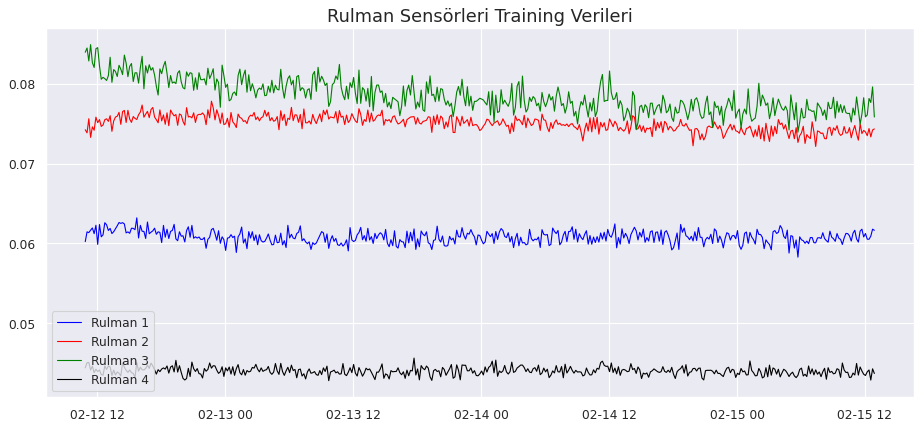

In [14]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Rulman 1'], label='Rulman 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Rulman 2'], label='Rulman 2', color='red', animated = True, linewidth=1)
ax.plot(train['Rulman 3'], label='Rulman 3', color='green', animated = True, linewidth=1)
ax.plot(train['Rulman 4'], label='Rulman 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Rulman Sensörleri Training Verileri', fontsize=16)
plt.show()

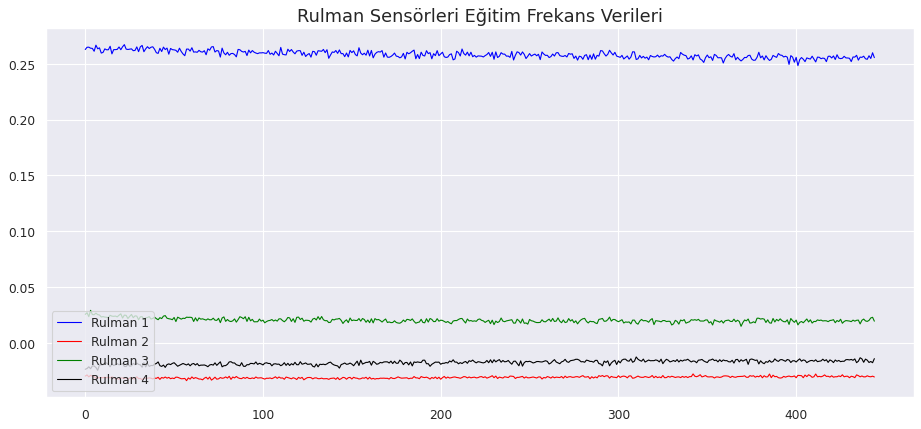

In [15]:
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Rulman 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Rulman 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Rulman 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Rulman 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Rulman Sensörleri Eğitim Frekans Verileri', fontsize=16)
plt.show()


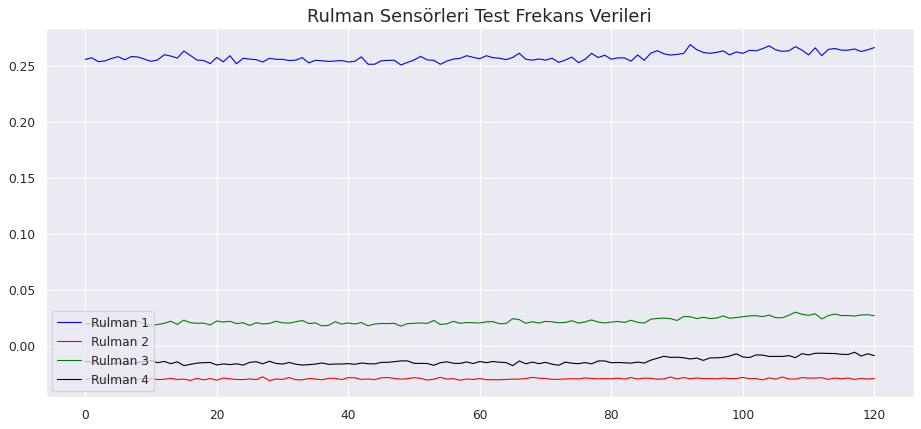

In [16]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Rulman 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Rulman 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Rulman 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Rulman 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Rulman Sensörleri Test Frekans Verileri', fontsize=16)
plt.show()


#### 5. Verileri Eğitim için Hazırlama

In [17]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)


['scaler_data']

In [18]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test shape:", X_test.shape)


Training shape: (445, 1, 4)
Test shape: (121, 1, 4)


#### 6. Modeli Kurma

In [19]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model


In [20]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1344      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

#### 7. Eğitim (Training)

In [21]:
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history


Epoch 1/100
43/43 [==============================] - 8s 26ms/step - loss: 0.4465 - val_loss: 0.3217
Epoch 2/100
43/43 [==============================] - 0s 7ms/step - loss: 0.3863 - val_loss: 0.2548
Epoch 3/100
43/43 [==============================] - 0s 8ms/step - loss: 0.3099 - val_loss: 0.1909
Epoch 4/100
43/43 [==============================] - 0s 7ms/step - loss: 0.2154 - val_loss: 0.1658
Epoch 5/100
43/43 [==============================] - 0s 6ms/step - loss: 0.1297 - val_loss: 0.1479
Epoch 6/100
43/43 [==============================] - 0s 6ms/step - loss: 0.1085 - val_loss: 0.1244
Epoch 7/100
43/43 [==============================] - 0s 6ms/step - loss: 0.1035 - val_loss: 0.1149
Epoch 8/100
43/43 [==============================] - 0s 6ms/step - loss: 0.1016 - val_loss: 0.1141
Epoch 9/100
43/43 [==============================] - 0s 7ms/step - loss: 0.1009 - val_loss: 0.1126
Epoch 10/100
43/43 [==============================] - 0s 7ms/step - loss: 0.1004 - val_loss: 0.1108
Epoch 11

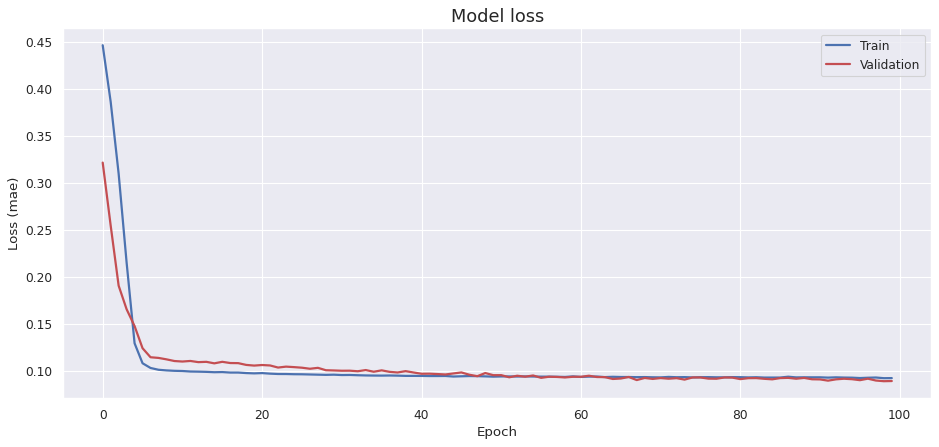

In [22]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()


14/14 [==============================] - 1s 3ms/step


<ipython-input-23-bce9dbc1da5d>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');


(0.0, 0.5)

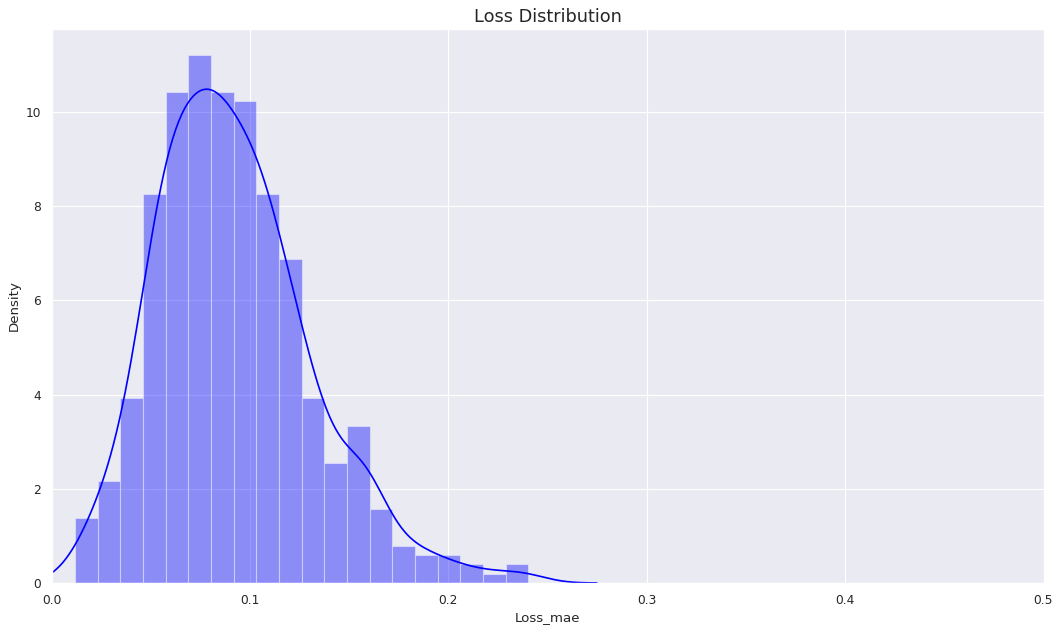

In [23]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

#### 8. Tespit (Prediction)

In [24]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.3
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()


4/4 [==============================] - 0s 3ms/step


,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.095770,0.3,False
2004-02-15 13:02:39,0.165516,0.3,False
2004-02-15 13:12:39,0.067352,0.3,False
2004-02-15 13:22:39,0.058325,0.3,False
2004-02-15 13:32:39,0.041346,0.3,False


In [25]:
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.3
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

14/14 [==============================] - 0s 2ms/step


<Axes: >

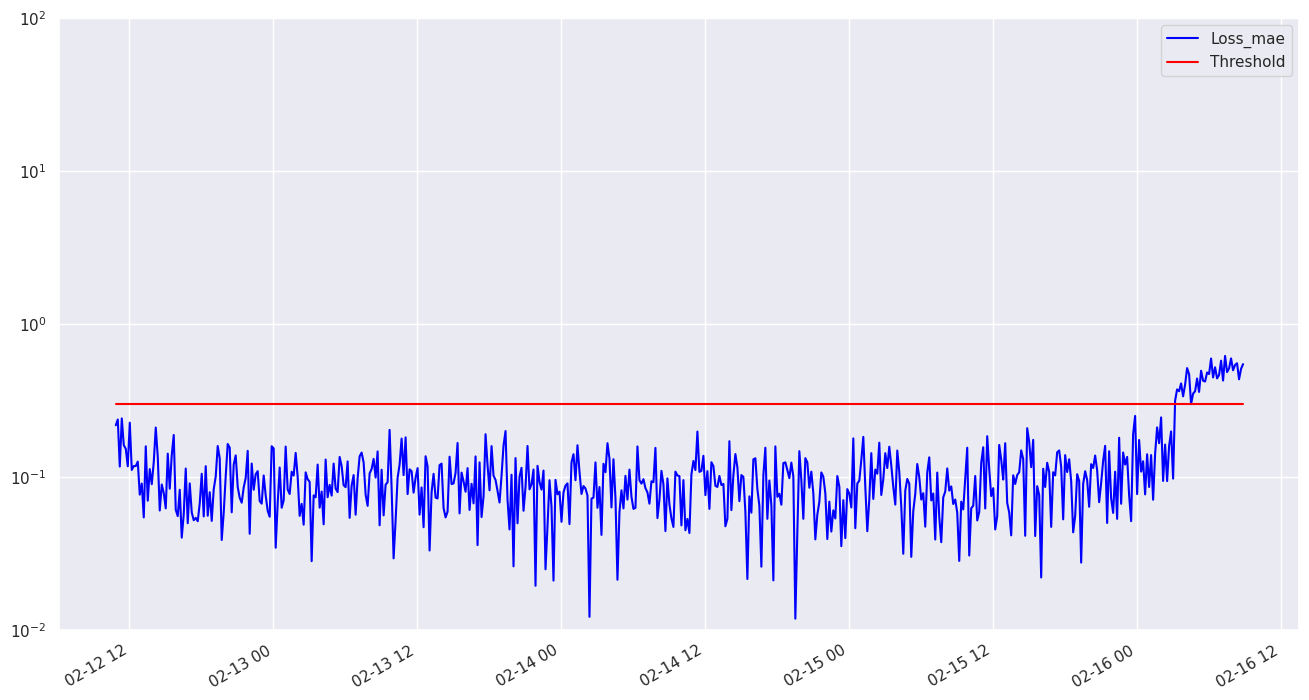

In [26]:
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

In [ ]:
model.save("model.h5")
print("Model Kaydedildi !")

Model Kaydedildi !
